In [243]:
#coding: UTF-8
%matplotlib inline
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time


colors=plt.rcParams['axes.color_cycle']#讀取預設顏色陣列
plt.rcParams['font.sans-serif'] = ['helvetica']  #默認字形
plt.rcParams['figure.figsize'] = 16, 12 # change size of images
#matplotlib.matplotlib_fname()

D:\anaconda\1\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Data

D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


D:\FGD\data\Anxiety.txt


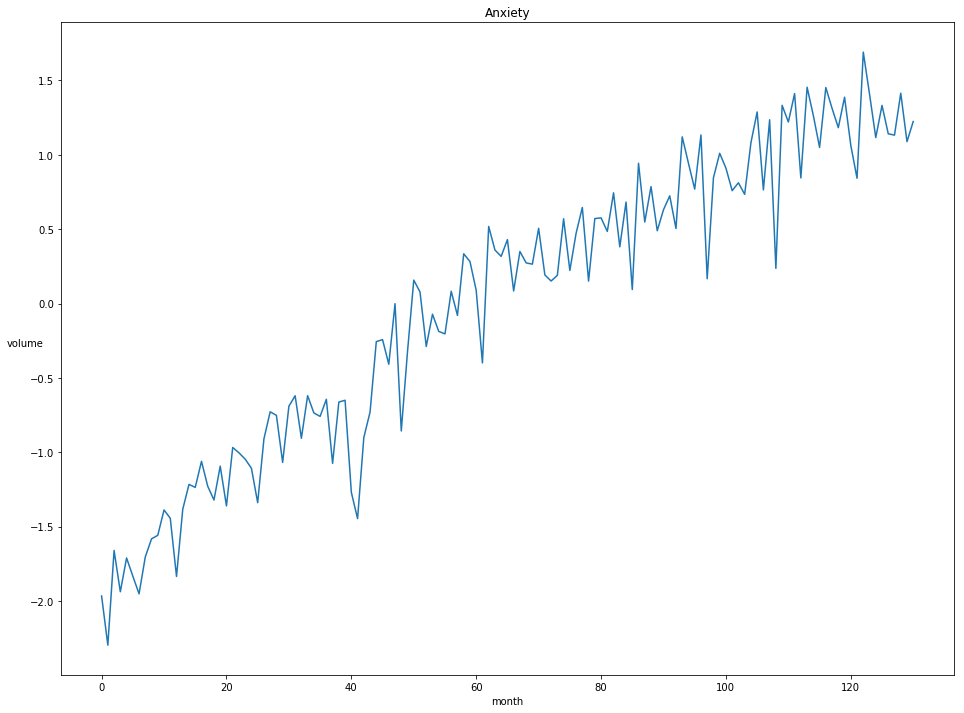

In [244]:
# open file and show data

picsavepath = 'D:\\FGD\\pics\\'
%store -r path_data
print(path_data)
inputdataname = 'D:\\FGD\\data\\Anxiety.txt'
f = open(inputdataname, 'r',encoding='utf-8')
data = [float(line.strip()) for line in f.readlines()]
data[:]
plt.plot(data)
plt.xlabel('month',fontproperties='helvetica')
plt.ylabel('volume',fontproperties = 'helvetica',rotation = 'horizontal')

code_name = inputdataname.split('\\')[-1].split('.')[-2]
plt.title(code_name)
plt.savefig(picsavepath+code_name+'_timespace')
plt.show()

## Frequency Spectrum

D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


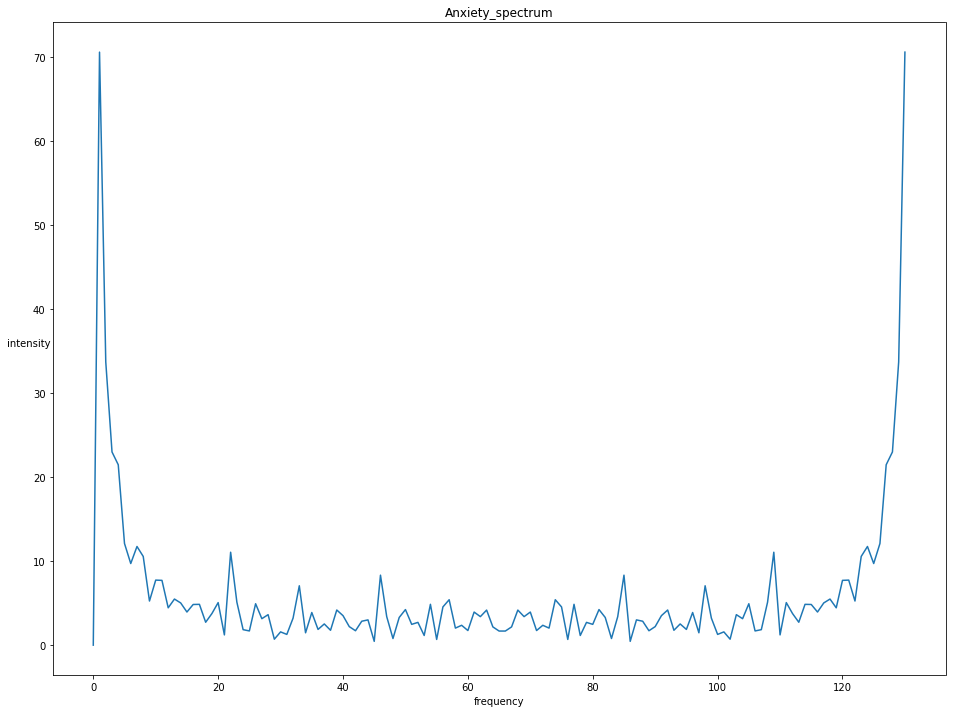

In [245]:
# generate the frequency spectrum of the data

sp = np.fft.fft(data)
sp[:10]

# plot the fft

# magnitude
avg = sp[0]
sp[0]=0 #remove the average first
sp_abs = np.absolute(sp)
plt.plot(sp_abs)
plt.xlabel('frequency',fontproperties = 'helvetica')
plt.ylabel('intensity',fontproperties = 'helvetica',rotation = 'horizontal')
plt.title(code_name+'_spectrum')
plt.savefig(picsavepath+code_name+'_spectrum')
def xs(y): return range(len(y))


D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


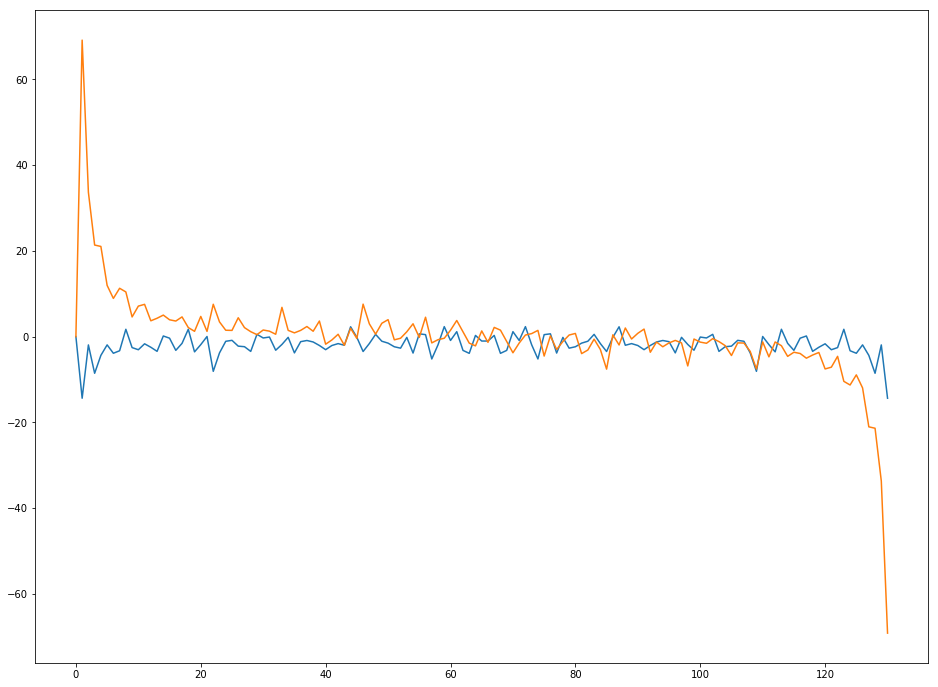

In [246]:
plt.plot(np.real(sp))
plt.plot(np.imag(sp))


# Finding Spikes

D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[(1, 70.624984423011639), (7, 11.749295437214316), (22, 11.066586929512845)]
top_peaks 3
131.0
18.7142857143
5.95454545455


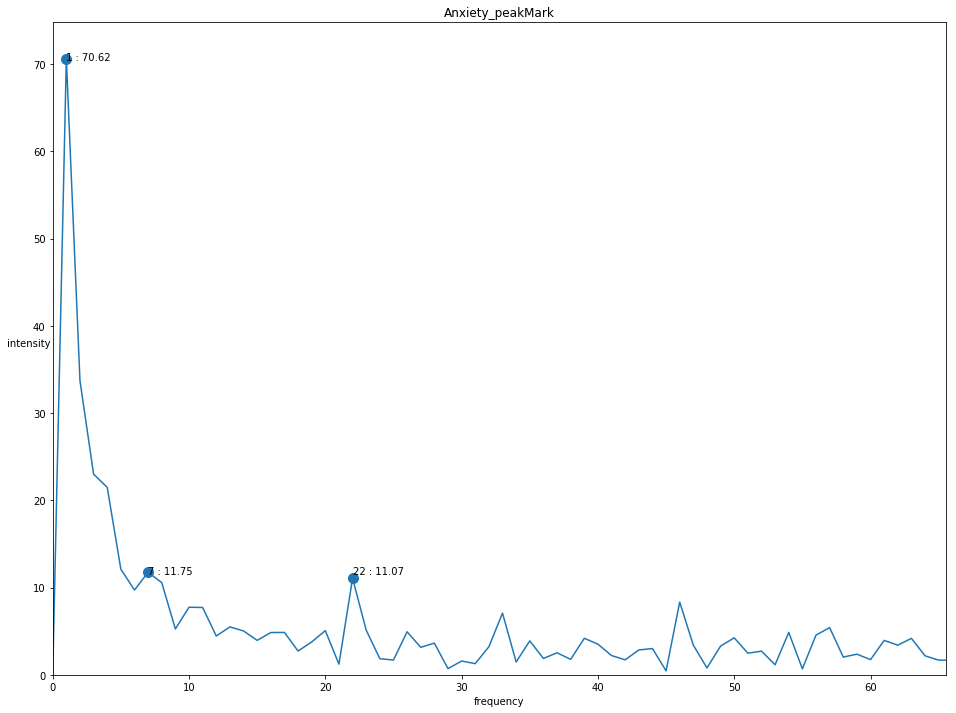

In [247]:
# find peaks usng threshold 
# -- peaks that are higher than a threshold is considered significant (as compared to the highest peak)

threshold_percent_max_peak = 0.14

from scipy.signal import argrelextrema

peaks = argrelextrema(sp_abs[:len(sp_abs)//2], np.greater)[0]

valleys = argrelextrema(sp_abs[:len(sp_abs)//2], np.less)[0]

# list of x, y of the peaks
peaks_w_vals = [(x, sp_abs[x]) for x in peaks]

top_peaks_raw = sorted(peaks_w_vals, key=lambda x:x[1], reverse=True)
threshold = top_peaks_raw[0][1] * threshold_percent_max_peak

top_peaks = [x for x in top_peaks_raw if x[1] > threshold]

# show the spectrum and plot the peaks
t = np.transpose(top_peaks)
plt.plot(xs(sp), sp_abs)
plt.scatter(t[0], t[1], s=100, marker="o")
plt.axes()
plt.xlim(0, len(sp)/2)
plt.ylim(0)

for i in top_peaks:
    plt.annotate('{0} : {2:.2f}'.format(str(i[0]),'_',i[1]),xy=( int(i[0]) ,int(i[1])), xytext=( int(i[0]) ,int(i[1])+threshold*0.05) )

plt.xlabel('frequency',fontproperties = 'helvetica')
plt.ylabel('intensity',fontproperties = 'helvetica',rotation = 'horizontal')
plt.title(code_name+'_peakMark')
plt.savefig(picsavepath+code_name+'_peakMark')

print(top_peaks)

print ('top_peaks',len(top_peaks))
for i in top_peaks:
    print(len(sp)/i[0])#週期為頻率的倒數

plt.show()

range(1, 6) [70.624984423011639, 33.726610980207411, 23.007588356282106, 21.482741707645925, 12.107230949992189]
range(6, 9) [9.7205190071859455, 11.749295437214316, 10.566008834780559]
range(21, 25) [1.2206191805268209, 11.066586929512845, 5.1159189347132497, 1.8444475080057772]


D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[range(1, 6), range(6, 9), range(21, 25)]

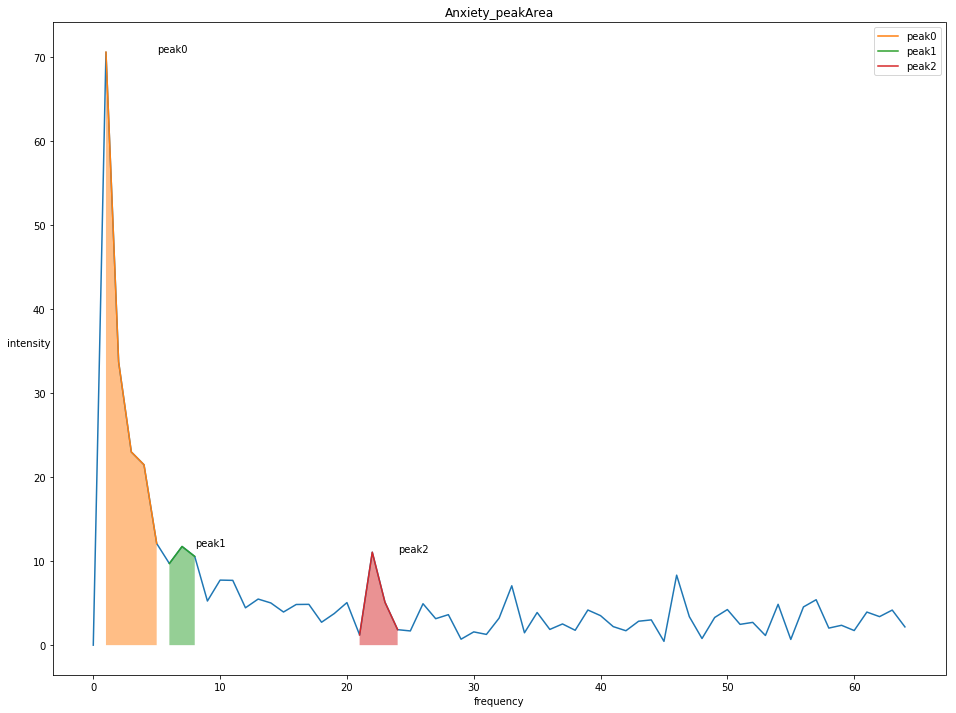

In [248]:
# Given the peak, find the whole frequency spike that contains the peak. 
# returns a list of the groups of the x values of each spike

# Automatically find spike ranges by assuming that the spike is the location from
# one valley through the peak to the next valley

def closestRange(valleys, peak_x, maxIndex):
    """ find the range of the spike (valley, peak, valley] that contains the peak """
    from bisect import bisect_left

    pos = bisect_left(valleys, peak_x)
    if pos == 0: # peak before first valley
        return range(1, valleys[0])
    elif pos == len(valleys): # peak after last valley
        return range(valleys[-1], maxIndex)
    else:
        return range(valleys[pos - 1], valleys[pos])

spikes = [closestRange(valleys, x, len(sp_abs)-1) for x, val in top_peaks]


# finds the y values of a spike (x1,x2,x3) -> (y1,y2,y3)
def gen_vals(arr):
    return lambda r: [arr[i] for i in r]
# pre process the spectrum values for a function that to find the spike values
vals = gen_vals(sp_abs)

# draws the spikes
size = int(len(sp_abs)/2)  # size of the original frequency spectrum to draw
#to_plot = [xs(sp_abs)[:size], sp_abs[:size]]
#for s in spikes:
    #to_plot.append(s)
    #to_plot.append(vals(s))

#plt.plot(*to_plot)

base_plot = [xs(sp_abs)[:size], sp_abs[:size]]#原始頻譜線
plt.plot(*base_plot)#繪製頻譜

to_plot=[]#儲存peak線段

#繪製peak區域 以及上色
for count,s in enumerate(spikes):
    to_plot.append(s)
    to_plot.append(vals(s))
    _peakname = 'peak'+str(count)
    plt.plot(s,vals(s),c=colors[(count+1)%len(colors)],label = _peakname )
    print(s,vals(s))
    plt.annotate(_peakname,xy=(s.stop-1,max(vals(s))))
    plt.fill_between(s,vals(s),0,facecolor=colors[(count+1)%len(colors)],alpha=0.5)

plt.xlabel('frequency',fontproperties = 'helvetica')
plt.ylabel('intensity',fontproperties = 'helvetica',rotation = 'horizontal')
plt.title(code_name+'_peakArea')
plt.legend()
plt.savefig(picsavepath+code_name+'_peakArea')

spikes

# Isolated periodic components

In [249]:
# helper funcs

# For a given spike, it is mirrored on each half of the spectrum, 
# these functions helps fetch the frequency values given a spike.
# this can help in performing inverse DFT

def isolate_range(arr, rang):
    """ given an array, isolate the range 
    ie the items in the range contain the original values, and zeros outside
    rang is a list of indexes of arr
    """
    ret = [0]*len(arr)
    for i in rang:
        if not (i < len(arr)): # out of range
            continue
        ret[i] = arr[i]
    return ret

def gen_sym(arr):
    """ partial eval of a function to find the symmetric range 
    """
    return lambda rang: list(rang) + [len(arr)-x for x in reversed(rang)]

sym = gen_sym(sp)
# sym is a function that takes a parameter, rang, for the range of the 
# spike at one half of the spectrum and returns both parts of the spike

# used like:
# > isolate_range(sp, gen_sym([1,2,3]))


## Draw the Frequencies

D:\anaconda\1\lib\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  
D:\anaconda\1\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


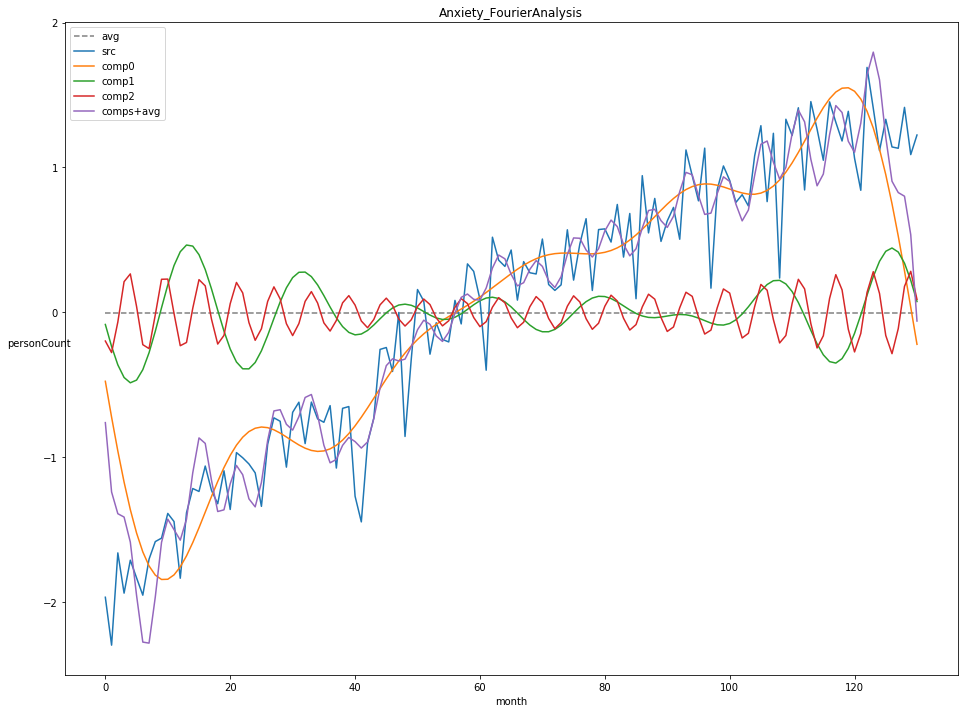

In [250]:
# Draws each frequency spike in the time domain.

len(spikes)

zeros = np.zeros(len(data))
zeros[0] = avg
combined = np.fft.ifft(zeros)
plt.plot(xs(data),combined,label = "avg",color = 'gray',ls='--')#先繪製平均線

# first draw the original data.
#plt.plot(xs(data), data)
src_line=plt.plot(xs(data), data,label = 'src')

# components in time domain
comps = []
#for s in spikes:
    #comp = np.fft.ifft(isolate_range(sp, sym(s)))
    #comps.append(comp.real)
    #combined = np.add(combined, comp)
    #plt.plot(xs(data), comp)

for _count,s in enumerate(spikes):
    comp = np.fft.ifft(isolate_range(sp, sym(s)))
    comps.append(comp.real)
    combined = np.add(combined, comp)
    plt.plot(xs(data), (comp),label='comp'+str(_count))

combine_line = plt.plot(xs(data),combined.real,label = 'comps+avg')

plt.xlabel('month',fontproperties = 'helvetica')
plt.ylabel('personCount',fontproperties = 'helvetica',rotation = 'horizontal')
plt.title(code_name+'_FourierAnalysis')
plt.legend()
plt.savefig(picsavepath+code_name+'_FourierAnalysis')

plt.legend()


In [251]:
# data with combined ifft peak components

#plt.plot(xs(data), data)
#plt.plot(xs(data), combined)
spikes

[range(1, 6), range(6, 9), range(21, 25)]

# Run Ame to find matching periodic gaussians

D:\anaconda\1\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


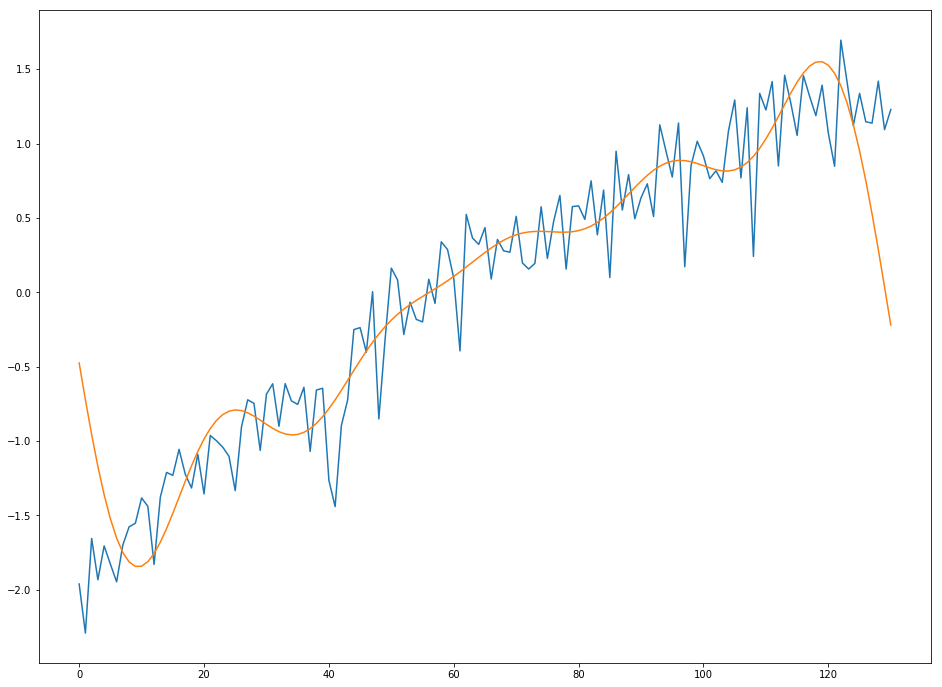

In [252]:
# finds trend + shows it 


s = [x for x in spikes if 1 in x][0]
trend = np.fft.ifft(isolate_range(sp, sym(s)))

plt.plot(xs(data), data-np.average(data), xs(trend), trend)


1
remove
6
7
8
21
22
23
24
[range(6, 9), range(21, 25)]


D:\anaconda\1\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
D:\anaconda\1\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


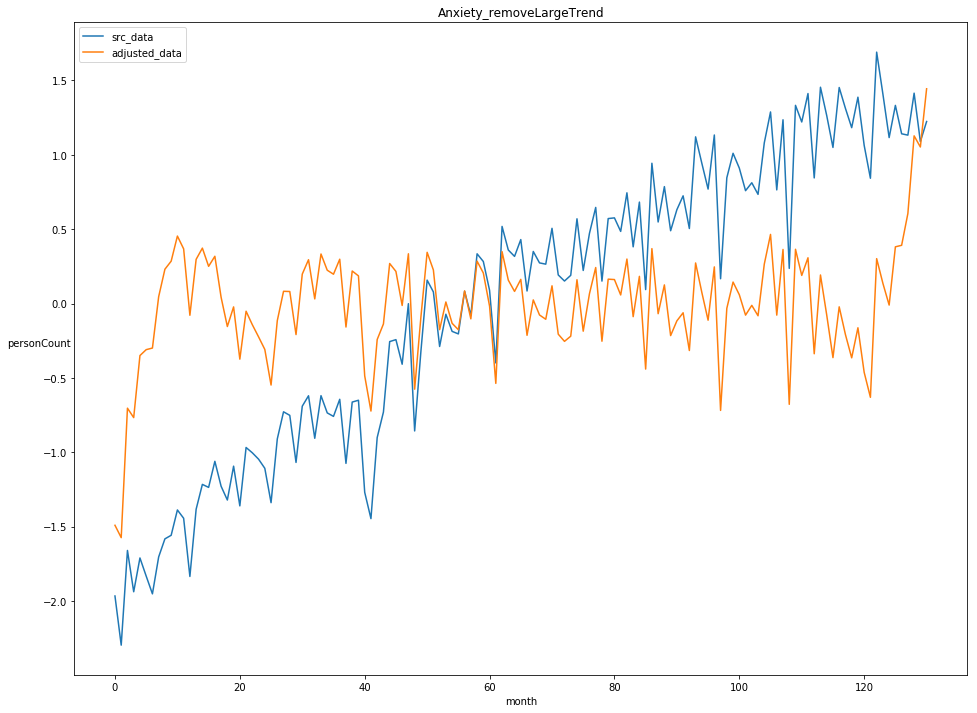

In [253]:

REMOVE_TREND = True
# optional -- remove large trends.
# trends are defined as spikes that are all contained within the first 5 frequency values

trend = []
spikesF = []
for s in spikes:
    #print(s)
    j = True
    for i in s:
        print(i)
        if(i == 1):
            print('remove')
            trend = np.fft.ifft(isolate_range(sp, sym(s)))
            j = False
            break
    
    if j:
        spikesF.append(s)
    #if max(s) < 5:
        #trend = np.fft.ifft(isolate_range(sp, sym(s)))

print(spikesF)
if REMOVE_TREND:
    adjusted_data = np.subtract(data, trend)
    #plt.plot(xs(data), data,
         #xs(data), adjusted_data)
else:
    adjusted_data = data

plt.plot(xs(data), data, label = 'src_data')
plt.plot(xs(data), adjusted_data , label = 'adjusted_data')
plt.legend()

plt.xlabel('month',fontproperties = 'helvetica')
plt.ylabel('personCount',fontproperties = 'helvetica',rotation = 'horizontal')
plt.title(code_name+'_removeLargeTrend')
plt.legend()
plt.savefig(picsavepath+code_name+'__removeLargeTrend')

plt.legend()

In [254]:
# Find the periods of each spike.

CALC_AVG_PERIOD = False
# Spikes can be a combination of multiple periods, so we have two ways of finding the period:
#  1. Spike periods are defined by the peak frequency (CALC_AVG_PERIOD = False)
#  2. Take the average peak-to-peak distance for the spike period (CALC_AVG_PERIOD = True)


peak_periods = []
if CALC_AVG_PERIOD:
    # peaks are in frequencies
    for i in xrange(len(top_peaks)):
        p,v = top_peaks[i]
        if p == 1:
            continue

        # peaks in component
        c_p = argrelextrema(comps[i], np.greater)[0]
        if len(c_p) > 5:
            c_p = c_p[1:-1] # if we have enough data, remove the first last, it might throw us off
        avg_period = sum([c_p[j+1] - c_p[j] for j in xrange(len(c_p)-1)]) / (len(c_p)-1.0)
        peak_periods.append((p,avg_period))
else:
    for p,v in top_peaks:
        if p == 1:
            continue
        peak_periods.append((p, len(sp)/p))

# three resulting data that contains the information of the periods of the spike

sorted_peaks = sorted([p for p,v in top_peaks if p != 1])
all_periods = [dict(peak_periods)[x] for x in sorted_peaks]

print(peak_periods)
print(sorted_peaks)


[(7, 18.714285714285715), (22, 5.9545454545454541)]
[7, 22]


In [255]:
# the AME algorithm processes one spike at a time, and larger frequencies may affect the 
# results of the smaller frequencies

def remove_peaks_smaller_than(adjusted_data, spikes, peak_threshold):
    """ remove the influence of previous spikes before trying to match with gaussian
    """
    print(peak_threshold)
    for s in spikes:
        print(s)
        if max(s) < peak_threshold:
        #if(min(s) < peak_threshold and peak_threshold < max(s)):
            print('remove')
            trend = np.fft.ifft(isolate_range(sp, sym(s)))
            adjusted_data = np.subtract(adjusted_data, trend)
    return adjusted_data


#test
#adjusted_data = remove_peaks_smaller_than(data, spikes, sorted_peaks[-1])

#plt.plot(xs(data), data,
#xs(data), adjusted_data)

#plt.plot(xs(data), adjusted_data)
#spikes

In [256]:
''' 
Generate files that AME needs to run.
 out_filename:     contains the data to fit against
 result_filename:  the filename of where results should be saved
 gen_params(...):  used to generate 'parameter.txt' for the parameters of AME
'''

" \nGenerate files that AME needs to run.\n out_filename:     contains the data to fit against\n result_filename:  the filename of where results should be saved\n gen_params(...):  used to generate 'parameter.txt' for the parameters of AME\n"

In [257]:
# save data for AME to use.

out_filename = 'data.dat' # TODO: change to random filename
result_filename = 'result.txt'

def save_data(adjusted_data):
    of = open(out_filename, 'w',encoding='utf-8')
    for l in adjusted_data:
        of.write("%f\n" % l )

    of.close()

In [258]:
# generate the parameter file
def gen_params(periods, sigmas = None, downward = False):
    if sigmas is None:
        sigmas = []
    
    param_file = open('parameter.txt', 'w',encoding='utf-8')
    
    param_file.write(out_filename + '\n')
    param_file.write(result_filename + '\n')

    # number of peaks
    num_peaks = len(periods)
    param_file.write("%d\n" % (num_peaks))

    # write peak periods
    for period in periods:
        param_file.write("%d\n" % int(round(period)))
        #param_file.write("%d\n" % period)

    # (optional peak sigma - array of 0~x)
    for sigma in sigmas:
        param_file.write("%d\n" % sigma)
    
    # (optional - 1 for downward spikes)
    if (len(sigmas) > 0 and downward):
        param_file.write("1\n")

    param_file.close()



In [259]:
# Use this function to generate the files necessary for processing a spike.

def gen_files_for_peak(data, spikes, sorted_peaks, i):
    t = []
    # make the data file
    result_data = remove_peaks_smaller_than(data, spikes, sorted_peaks[i])
    save_data(result_data)
    #save_data(data)
    
    
    # make the parameter file
    for x in range(NUM_GAUSSIANS):
        #for i in all_periods:
            #t.append(i);
        t.append(all_periods[i])
    gen_params(t)


In [260]:
all_periods

[18.714285714285715, 5.9545454545454541]

# Match gaussians

In [261]:
# run Ame

import os


def execute_ami(seeds = 5):
    ''' runs the ame program
    
    ami parameters: (more can be found by running -h)
     -d (3 x peak num)  --- dimension
     -i --- number of random seeds
     -N --- number of iterations (100000)
     -n --- number of independent runs 
    '''

    return os.system(".\\ame.exe -d %d -i %d -N %d -n 1 -s"%(num_peaks*3, seeds, seeds*100000*100))
    #return os.system("D:\\GFD\\ame_ready\\ame\\Debug\\ame.exe -d %d -i %d -N %d -n 1 -s"%(num_peaks*3, seeds, seeds*80000))


In [262]:
# analyze the results

def parse_results(filename=None):
    if filename is None:
        filename = result_filename
    rf = open(filename, 'r',encoding='utf-8')

    #like MSE: 1.944097
    mse = float(rf.readline().strip().split(':')[1])

    #like p:24	w:4.719246	c:5	sig:2.741103
    results = []
    l = rf.readline().strip()
    while l[:2] == "p:":
        pairs = l.split('\t')
        d = {}
        for p in pairs:
            y = p.split(':')
            d[y[0]] = float(y[1])
        results.append(d)
        l = rf.readline().strip()

    # graph of result
    # like 0.000000	0.177095	0.130121	0.046974
    # column 1 is normalized data
    # column 2 is objective function (combined)
    # column 3+ is each of the periodic gaussian functions

    tmp_table = []
    while l:
        tmp_table.append([float(x) for x in l.split('\t')])
        l = rf.readline().strip()

    table = np.array(tmp_table).transpose()
    rf.close()
    return mse, results, table


MAX_FREQ_THRESHOLD = 0.4

def fxns_above_threshold(results):
    fxn_weights = [r['w'] for r in results]
    max_weight = max(fxn_weights)
    return len([w for w in fxn_weights if w > max_weight * MAX_FREQ_THRESHOLD])


In [263]:
def plot_Job(cur_period, fig_i):
    mse, results, table = parse_results()
    #plot the results
    plt.figure(fig_i)
    for _count,col in enumerate(table):
        if _count == 0:
            plt.plot(xs(col), col, label = "without shorter frequency")
        elif _count == 1:
            plt.plot(xs(col), col, label = "gaussians combine")
        else:
            plt.plot(xs(col), col, label = "gaussian comp" + str(_count-2))

    maxpair=[]
    for i in table:
        position = (max(enumerate(i),key=lambda x: x[1])[0])
        mons = position%12+1
        value = max(enumerate(i),key=lambda x: x[1])[1]
        maxpair.append([position,value,mons])

    print(maxpair)
    for _count,_m_pair in enumerate(maxpair):
        _annotate_str = '{0}:{1}'.format(_m_pair[2],_m_pair[1])
        plt.annotate(_annotate_str,
                     xy=(_m_pair[0],_m_pair[1]),
                     xytext=(_m_pair[0]+2,_m_pair[1]+0.04),
                     arrowprops=dict(facecolor=colors[(_count%len(colors))], shrink=0))
    
    plt.legend()
    plt.xlabel('month',fontproperties = 'helvetica')
    plt.ylabel('scale',fontproperties = 'helvetica',rotation = 'horizontal')
    plt.title(code_name+'GaussianAnalysis_period_'+cur_period)
    plt.legend()
    plt.savefig(picsavepath+code_name+'GaussianAnalysis_period_'+cur_period)
    
    #plot the results
    #for col in table:
    #plt.plot(xs(col), col)

    '''
    # record the trials v1
    try:
    num_peaks_trials
    except NameError:
    num_peaks_trials = {}
    num_peaks_trials[num_peaks] = table
    #'''

    # record the trials v2
    try:
        trial_for_each
    except NameError:
        trial_for_each = {}
    trial_for_each[cur_period] = table

    try:
        trial_history
    except NameError:
        trial_history = []
    
    trial_history.append((NUM_GAUSSIANS, cur_index, mse, results, table))
    # todo: record as trial_for_each[period][# of gaussians]
    #'''

    mse, results, fxns_above_threshold(results)

    record_file = open(os.path.join(picsavepath,code_name+'_period_'+cur_period+'.Res'),'a+',encoding='utf-8')
    record_file.write('{3}\t{0}\t{1}\t{2}\n'.format(mse,results,fxns_above_threshold(results),code_name))
    record_file.close()

In [264]:
#def combine_work(cur_period, fig_i):
    #start = time.time()
    #execution_result = execute_ami()
    #end = time.time()
    #print ('execution result: %d, time: %d' % (execution_result, end - start))
    #plot_Job(cur_period, fig_i)

In [265]:
#NUM_GAUSSIANS = 3

#cur_index = 1

#num_spikes = len(spikes) - 1

#for i in range(num_spikes):
    #print('remove freq smaller than sorted_peak %d: %d' % (i, sorted_peaks[i]))
    ##gen_files_for_peak(data, spikes, sorted_peaks, cur_index)
    #gen_files_for_peak(data, spikes, sorted_peaks, i)
    #num_peaks = NUM_GAUSSIANS
    #cur_period = all_periods[i]
    #print('number of peaks: %d; current period: %f' % (num_peaks, cur_period))
    #cur_index_period = str(int(round(cur_period)))
    #combine_work(cur_index_period, i)

In [266]:
f.close()